Train a multilayer perceptron to compute the metric density for the 2PN waveform model.

In [1]:
from typing import Mapping, Tuple

import flows
import haiku as hk
import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tqdm.auto import trange

from diffbank.metric import get_density as _get_density
from diffbank.noise import Sn_aLIGO
from diffbank.utils import get_m1_m2_sampler
from diffbank.waveforms.twoPN_simple import amp, Psi

In [3]:
key = random.PRNGKey(20)
m_range = (1., 5.)
fs = jnp.linspace(20.0, 2000.0, 1000)
m1_m2_sampler = get_m1_m2_sampler(m_range, m_range)
get_density = jax.jit(lambda theta: _get_density(theta, amp, Psi, fs, Sn_aLIGO))

In [4]:
Batch = Mapping[str, jnp.ndarray]
leaky_relu = jax.jit(lambda x: jax.nn.leaky_relu(x, 0.02))


def net_fn(batch: Batch) -> jnp.ndarray:
    mlp = hk.Sequential(
        [
            hk.Linear(128),
            leaky_relu,
            hk.Linear(128),
            leaky_relu,
            hk.Linear(1, b_init=hk.initializers.Constant(1.5)),
        ]
    )
    return mlp(batch["theta"]).squeeze(-1)


def get_batch(key, size: int = 512) -> Batch:
    thetas = m1_m2_sampler(key, size)
    densities = jnp.log10(jax.vmap(get_density)(thetas))
    return dict(theta=thetas, density=densities)


# Make net and optimizer
net = hk.without_apply_rng(hk.transform(net_fn))
opt = optax.adam(1e-2)


def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
    """Compute loss"""
    pred = net.apply(params, batch)
    return jnp.sum((pred - batch["density"]) ** 2)


@jax.jit
def update(
    params: hk.Params, opt_state: optax.OptState, batch: Batch
) -> Tuple[hk.Params, optax.OptState]:
    """Learning rule"""
    value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, value


# Initialize net and optimizer
key, subkey = random.split(key)
params = net.init(subkey, get_batch(subkey))
opt_state = opt.init(params)

# Training loop
train_losses = []
val_losses = []
val_interval = 10
n_steps = 200
with trange(n_steps) as pbar:
    for i in pbar:
        # Validation step
        if i % val_interval == 0:
            key, subkey = random.split(key)
            val_loss = loss(params, get_batch(subkey))
            val_losses.append(val_loss)
            pbar.set_description(f"val: {val_losses[-1]}")

        # Training step
        key, subkey = random.split(key)
        params, opt_state, train_loss = update(params, opt_state, get_batch(subkey))
        train_losses.append(train_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

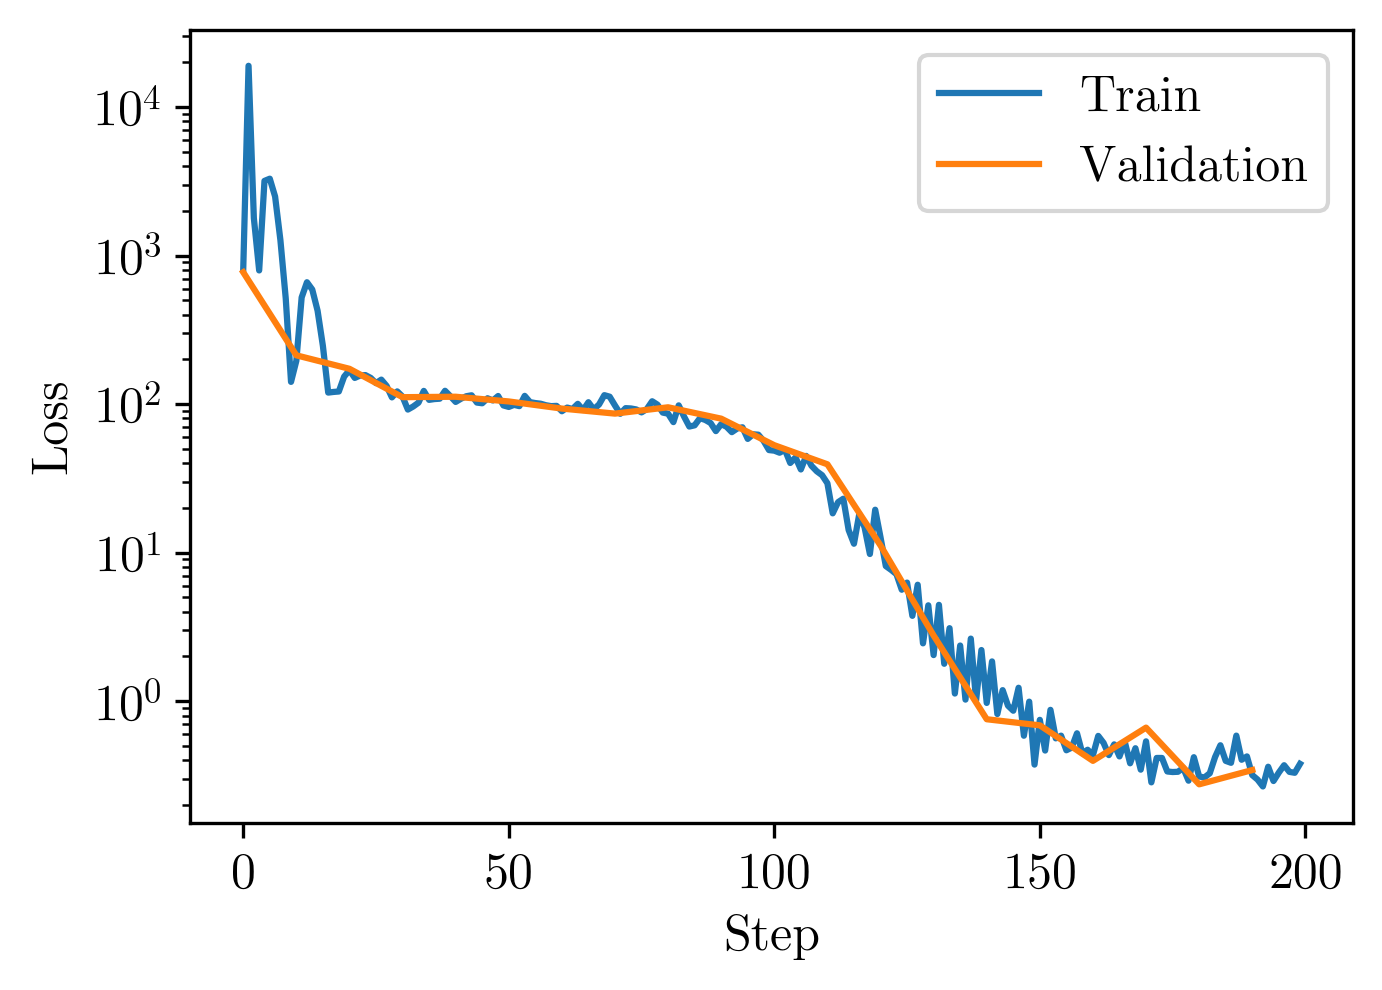

In [5]:
plt.semilogy(train_losses, label="Train")
plt.semilogy(jnp.arange(0, n_steps, val_interval), val_losses, label="Validation")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()

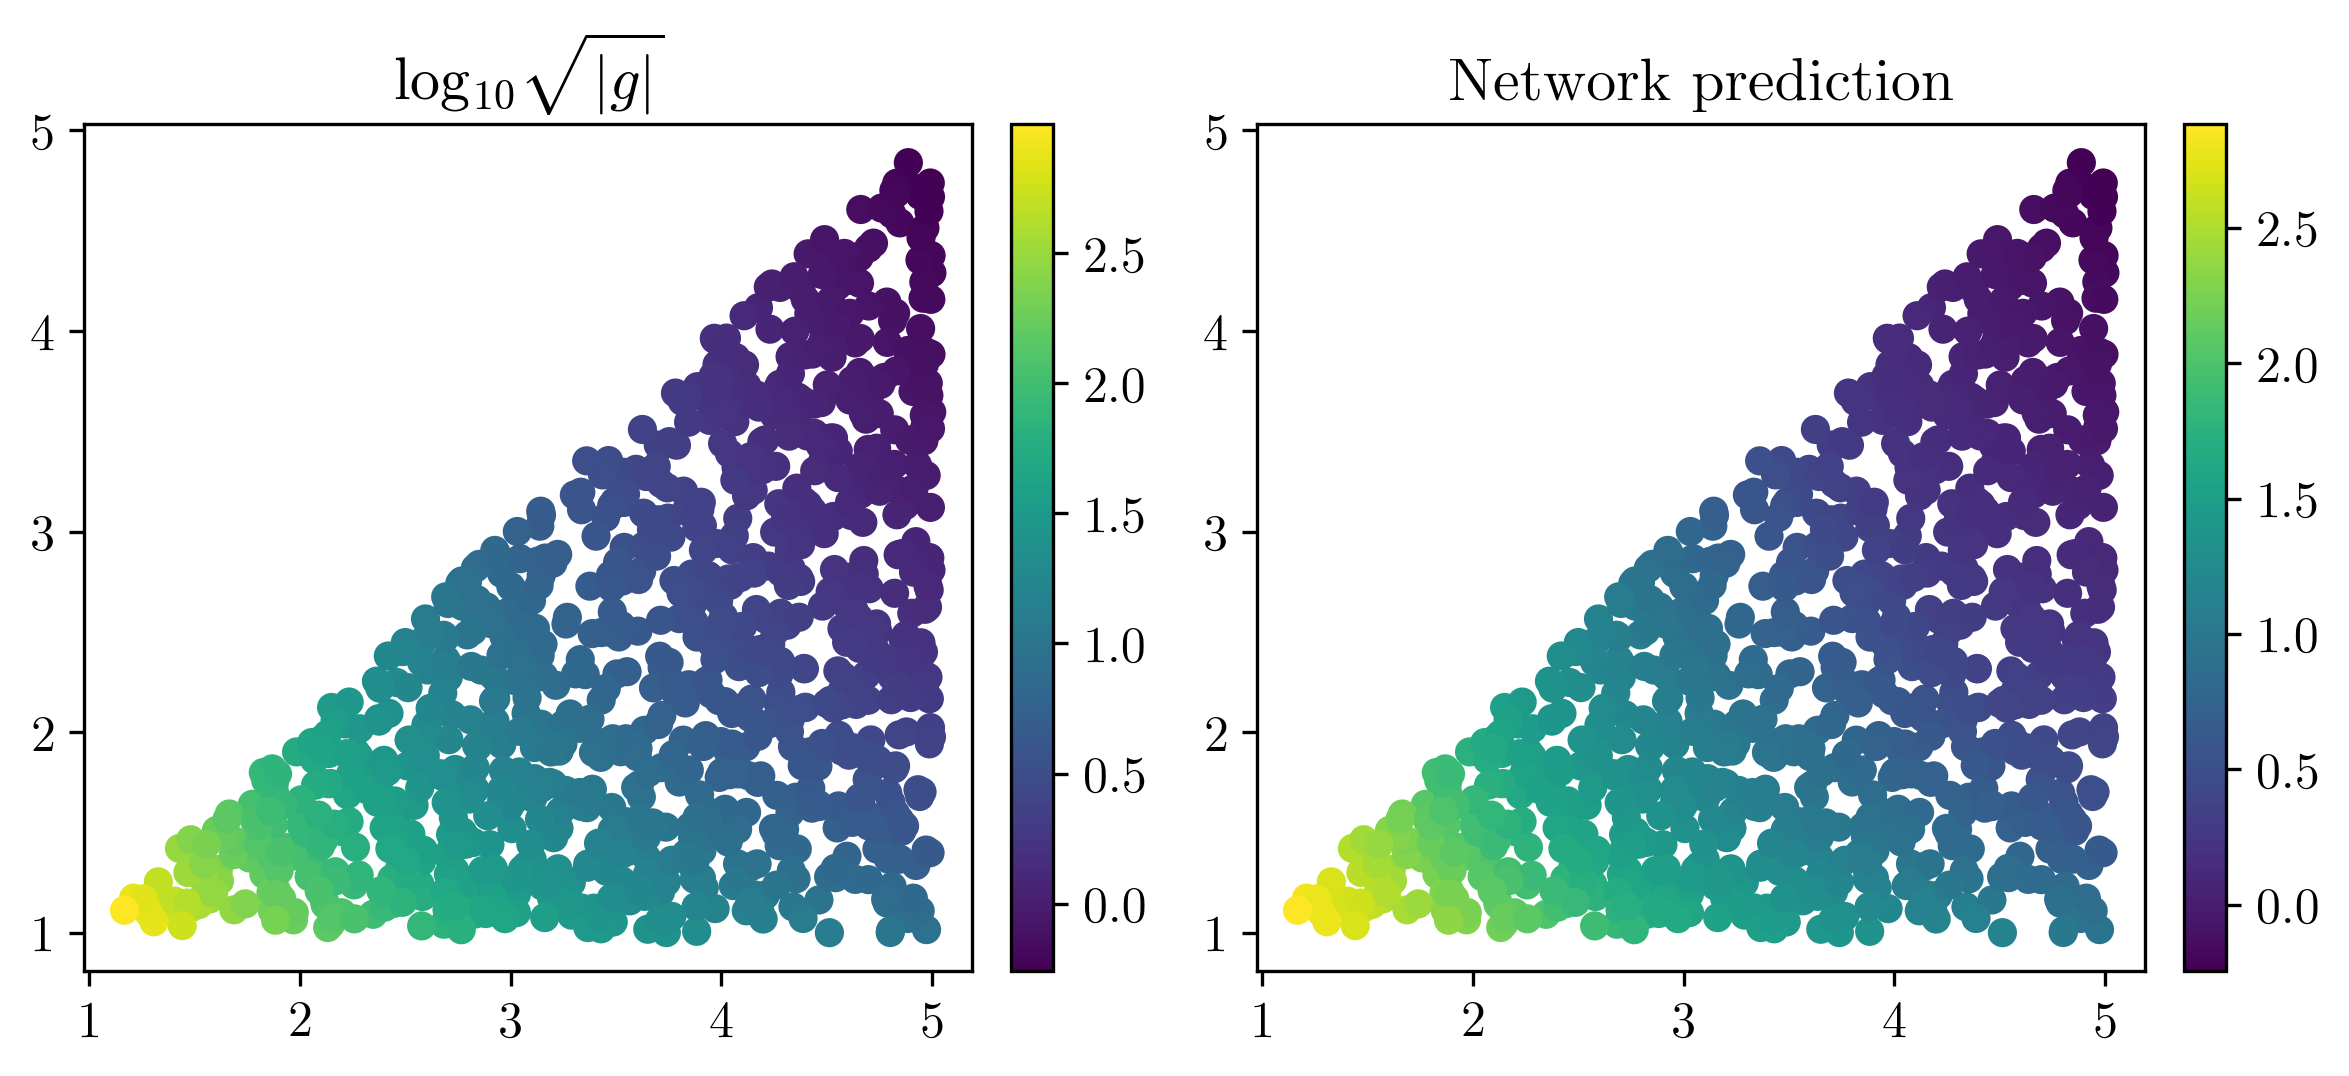

In [6]:
key, subkey = random.split(key)
batch = get_batch(subkey, 1000)

plt.figure(figsize=(8, 3.75))
plt.subplot(1, 2, 1)
plt.scatter(*batch["theta"].T, c=batch["density"])
plt.colorbar(fraction=0.046, pad=0.04)
plt.title(r"$\log_{10} \sqrt{|g|}$")

plt.subplot(1, 2, 2)
plt.scatter(*batch["theta"].T, c=net.apply(params, batch))
plt.colorbar(fraction=0.046, pad=0.04)
plt.title("Network prediction")

plt.tight_layout()